In [24]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from   sklearn.linear_model import LinearRegression

In [ ]:
# Upload Data
ufc = pd.read_csv('clean_ufc.csv')

### Introduction
The Ultimate Fighting Championship is the greatest sporting league ever. It is simply riveting to watch two trained assassins step into a caged Octagon and attempt to legally kill each other. Whole careers can be decided by one decisive punch and that element of unpredictability is what makes the sport so damn entertaining. But, can we tame this unpredictability using the power of computing and data science. My research question is can we build a model that predicts fight outcomes well enough that it would have historically won money using Las Vegas Gambling Odds. 
* What are your main findings? No
* Include a brief summary of your results. No

#### Data Description
1. What are the observations and the attributes?   
Each observation is one fighter in one bout. The attributes capture the statistics that were available at the time of the event for each fighter. Most of the information is the rate of a certain action per fifteen minutes. For example, column B_avg_SIG_STR_landed displays a fighter’s significant strikes landed per fifteen minutes. 
1. Why was this dataset created?     
The dataset was created on Kaggle and it hosts competitions for predicting the outcomes for upcoming UFC fights. There are several authors and the most prominent custodian, Matt Dabbert a graduate student at ASU, web scraped the gambling data in the hopes of creating a profitable UFC gambling algorithm using machine learning. 
1. Who funded the creation of the dataset?    
The raw data comes from UFCStats.com or sportsbets.com. Sportsbets.com is a online sportsbooks that makes money through setting gambling lines where they are likely to make money. The UFC hosts and televises fights and keeping record is an important part of nerdy fan interaction with the sport. The data scientists that cobbled the dataset together did not state that they were compensated. However, I'd imagine that Matt Dabbert is hoping to create a profitable betting algorithm. 
1. What processes might have influenced what data was observed and recorded and what was not?    
The UFC is where only well-established fighters perform. All the fighters listed in the dataset have an extensive amateur career that is not included.  The data from any fight outside of the UFC is not considered because there is no central Mixed Martial arts database and other organizations have different rules that would affect a fighter’s data. 
1. What preprocessing was done, and how did the data come to be in the form that you are using?    
The dataset comes from three different datasets that were combined. Rajeev Warrier’s dataset was the original dataset, and it contains data for every bout from 1993-2019. Before 2010, the data was improperly recorded and is not included in the final version. Mart Jurisoo compiled the ranking for every fighter. Matthew Dabbert scraped the gambling dataset and concatenated the three together to create the final version. On Kaggle, it lists thirty two unique contributors to the dataset but does not state their individual contributions. 
1. If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?    
It is not clear whether the fighters were aware of the data collection. I am assuming they are indifferent because they voluntarily put themselves in an incredibly vulnerable position where the whole world can watch them get absolutely embarassed. As a result, I do not think they would have qualms over their fight data being shared. 
1. Where can your raw source data be found, if applicable? Provide a link to the raw data? <br/> 
There have been over 500 UFC events and Dabbert scraped the statistics from an html file from each event. Since I did not think it would be a good use of time to manually download every html file and transfer it to Cornell Box, here is a link to the github page where all the raw source data is housed: https://github.com/shortlikeafox/tiger-millionaire/tree/master/scrape_all_events/event_webpages 
1. If others want to extend/augment/build on/contribute to the dataset, is there a mechanism for them to do so? <br/>
Yes, the data is publicly available on Github. Different users can suggest updates and even send the custodian different versions of the dataset that are posted by the owner. Ultimately, Matthew Dabbert has jurisdiction of how the dataset changes. 
1. Has the dataset been used for any tasks already? <br/>
Community members have used the dataset to create visualizations for data reports. The goal of the dataset is to be a public site to merge all UFC datasets. Some users have selectively taken parts of the dataset and combined with their smaller datasets to create specialized fight datasets. 
1. What (other) tasks could the dataset be used for? <br/>
The dataset might be useful to UFC executives if they are trying to determine whether a fighter will retire. This is important information because fighters often sign multi-fight contracts and if they retire early, the UFC can lose money on that contract. 

### Pre-registration statement
##### Multiple Regression Analysis
* I will preform a multiple regression analysis with four variables that have the highest level of correlation with a fighter winning. I will subset the last hundred UFC fights in the dataset for the the test split and the rest of the dataset will be used for training the regression model. The regression model will be used to predict fight outcomes. I  I will bet one hundred dollars on each fighter that is predicted to win. Then I will calculate the profits that I would earn using the predictions. Then using a permutation test I see whether the results are significant. 

### Data Analysis
* Use summary functions like mean and standard deviation along with visual displays like scatterplots and histograms to describe data.
* Provide at least one model showing patterns or relationships between variables that addresses your research question. This could be a regression or clustering, or something else that measures some property of the dataset.

In [25]:
# Upload Data
ufc = pd.read_csv('clean_ufc.csv')

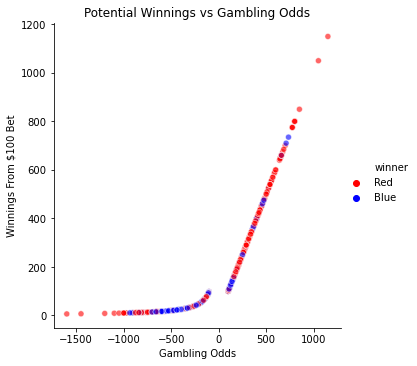

In [26]:
# Scatter plot for odds and potential winnings
sns.relplot(x='odds', y='ev', alpha = .6, hue='winner', palette = ('Red', 'Blue'), data=ufc)
plt.xlabel('Gambling Odds')
plt.ylabel('Winnings From $100 Bet')
plt.title('Potential Winnings vs Gambling Odds')
plt.show()

#### Explanation of Gambling Odds
The gambling odds model the probability that a fighter will win in terms of how much money a gambler will win if there chosen fighter wins. If a gambler bets \\$100 on a fighter with +500 odds, they will win \\$500 given that the fighter wins. The reason payoff is high relative to the bet is because Las Vegas thinks the fighter has a low probability of winning. Negative gambling odds work a little differently. When a fighter has -500 odds, that means a gambler would have to wager \\$500 to win \\$100 because that the chosen fighter is a heavy favorite to win. 
#### Why does the distribution look like this? 
The diagram above shows the relationship between potential winnings and gambling lines. There tends to be more red winners because the "red" fighter is the more established fighter and is normally expected to win. Also, the payoffs on underdogs is much greater than the pay offs on favorites. This is important for our model because we should prioritize choosing underdogs because they earn higher payoffs. 

In [57]:
# Create a dataset whether fighter is favorites that win vs underdogs that win
win = ufc[ufc['win_dum'] == 1]
fav_win = win[ufc['status'] == 'favorite']
und_win = win[ufc['status'] == 'underdog']
x_axis = ['Underdog', 'Favorite']
y_axis = [((len(und_win) / 1003) * 100), ((len(fav_win) / 1003) * 100)]

<ipython-input-57-87d4f9e6f04d>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fav_win = win[ufc['status'] == 'favorite']
<ipython-input-57-87d4f9e6f04d>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  und_win = win[ufc['status'] == 'underdog']


In [58]:
# Finding average return on different winners
average_fav_value = fav_win['ev'].mean()
average_und_value = und_win['ev'].mean()
y2_axis = [average_und_value, average_fav_value]

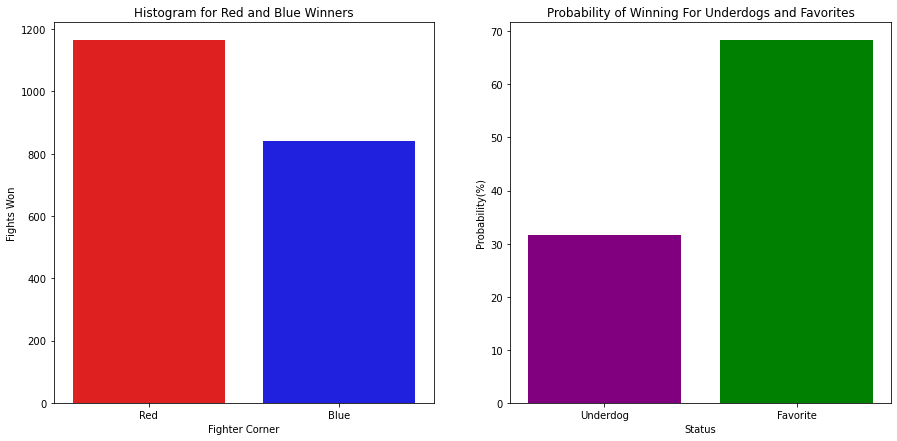

In [59]:
# Histogram for winning red vs blue
# Add red for red winners and blue for blue winners
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.countplot(ufc['winner'], palette = ('Red', 'Blue'), data=ufc)
plt.xlabel('Fighter Corner')
plt.ylabel('Fights Won')
plt.title('Histogram for Red and Blue Winners')
# Graph for winners that are underdogs and winners that are favorites by percentage?

plt.subplot(1,2,2)
plt.bar(x_axis, y_axis, color = ['purple', 'green'])
plt.xlabel('Status')
plt.ylabel('Probability(%)')
plt.title('Probability of Winning For Underdogs and Favorites')

plt.show()

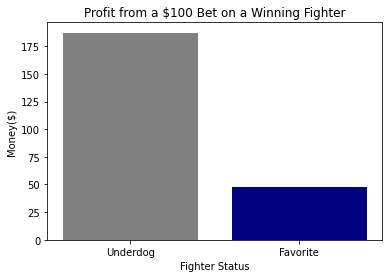

In [70]:
# Graph for average return on underdog winner and average return for favorite winner
plt.bar(x_axis, y2_axis, color = ['Grey', 'Navy'])
plt.ylabel('Money($)')
plt.xlabel('Fighter Status')
plt.title('Profit from a $100 Bet on a Winning Fighter')
plt.show()

In [87]:
ufc_corr = pd.DataFrame()
for col in ufc.columns:
    if ufc[col].dtype == 'float64':
        ufc_corr[col] = ufc[col]

In [97]:
col_corr.head()

,col_name,col_corr


In [103]:
# Create new dataframe with columns and correlation coefficients
col_corr = pd.DataFrame(columns = ['col_name', 'corr'])
for col in ufc_corr.columns:
    corr = ufc['win_dum'].corr(ufc_corr[col])
    new_row = {'col_name': col, 'corr': corr}
    col_corr = col_corr.append(new_row, ignore_index=True)

In [106]:
type(col_corr)

pandas.core.frame.DataFrame

In [108]:
# Sort 
sort_by_corr = col_corr.sort_values('corr')
sort_by_corr.head(n=4)

,col_name,corr
54,odds,-0.377234
53,ev,-0.340515
30,age,-0.122519
39,win_by_decision_split,-0.102847


Now we have our four columns that are most highly correlated with a fighter winning or losing. Now time to plug into our multiple regression model. 

In [109]:
# Linear regression using fight differences 
multi_model = LinearRegression()
multi_model.fit(ufc[['odds', 'ev', 'age', 'win_by_decision_split']], ufc['win_dum'])
print('Takedown Difference Regression Coefficient', multi_model.coef_[0])
print('Strike Difference Regression Coefficient', multi_model.coef_[1])
print('Reach Difference Regression Coefficient', multi_model.coef_[2])
print('Experience Difference Regression Coefficient', multi_model.coef_[3])

Takedown Difference Regression Coefficient -0.000516885426846336
Strike Difference Regression Coefficient -0.00027770850028200207
Reach Difference Regression Coefficient -0.0036962884761124566
Experience Difference Regression Coefficient -0.04690181206076676


In [122]:
# Correlation Coefficient for Multiple Regression Model
multi_pred = multi_model.predict(ufc[['odds', 'ev', 'age', 'win_by_decision_split']])
multi_corr = np.corrcoef(multi_pred, ufc['win_dum'])[0,1]
print('Multiple Regression Correlation Coefficient: {:}'.format(round(multi_corr,2)))

Multiple Regression Correlation Coefficient: 0.39


In [127]:
# Add column that holds multiple regression prediction
ufc['multi_pred'] = multi_pred

In [133]:
# Make new column for whether multiple regression predicts win or loss
ufc['multi_dummy'] = 0
for i in ufc.index:
    if ufc.loc[i, 'multi_pred'] >= .5:
        ufc.loc[i, 'multi_dummy'] = 1
ufc_pred = ufc[ufc['multi_dummy'] == 1]
ufc_correct = ufc_pred[ufc['win_dum'] == 1]

<ipython-input-133-c9836cfe153a>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ufc_correct = ufc_pred[ufc['win_dum'] == 1]


In [137]:
perc_correct = (len(ufc_correct)/ 1003) * 100

In [138]:
print('Correct Prediction Percentage: {:}'.format(perc_correct))

Correct Percentage: 67.39780658025923


In [148]:
# Calculate Winnings
revenue = (ufc_correct['ev'].sum())
costs = ((1003-len(ufc_correct)) * 100)
profit = revenue - costs
print('Profit from Bets: ${:.2f}'.format(profit))

Profit from Bets: $-363.69


-363.6889967780007


In [80]:
# Leads into Multiple Regression Analysis With Appropiate Variables 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 71 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   empty_arena                 2006 non-null   float64
 1   constant_1                  2006 non-null   float64
 2   avg_td_dif                  2006 non-null   float64
 3   avg_sub_att_dif             2006 non-null   float64
 4   sig_str_dif                 2006 non-null   float64
 5   age_dif                     2006 non-null   float64
 6   reach_dif                   2006 non-null   float64
 7   height_dif                  2006 non-null   float64
 8   sub_dif                     2006 non-null   float64
 9   ko_dif                      2006 non-null   float64
 10  total_title_bout_dif        2006 non-null   float64
 11  total_round_dif             2006 non-null   float64
 12  loss_dif                    2006 non-null   float64
 13  win_dif                     2006 

### Evaluation of significance. 

* Use hypothesis tests, simulation, randomization, or any other techniques we have learned to compare the patterns you observe in the dataset to simple randomness. 
* For linear regression we can do a permutation test to see whether results are significant
* Then use random method and see how likely outcomes is 
* Permutation you shuffle the data output(winning) and calculate certain statistics 

### Interpretation and Conclusions
* What did you find over the course of your data analysis, and how confident are you in these conclusions? Detail your results more so than in the introduction, now that the reader is familiar with your methods and analysis. Interpret these results in the wider context of the real-life application from where your data hails.

### Limitations
* What are the limitations of your study? What are the biases in your data or assumptions of your analyses that specifically affect the conclusions you’re able to draw?

##### Data Limitations
Other users have complained that the dataset mixes up which fighter is the red or blue fighter. This a problem because it would incorrectly swap the fighters' data. The sample size for most fighters is small. Most fighters only fight two times a year and because of the sport’s violent nature, they often have short careers. This leaves most fighters with only a couple fights that we can use to statistically evaluate them. 

### Source Code
* Provide a link to your Github repository (or other file hosting site) that has all of your project code (if applicable). For example, you might include web scraping code or data filtering and aggregation code.

### Acknowledgments. 
* Recognize any people or online resources that you found helpful. These can be tutorials, software packages, Stack Overflow questions, peers, and data sources. 

### Question for Reviewers